<a href="https://colab.research.google.com/github/jinsooya/emba/blob/main/09_ai-agent-business-strategy-report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

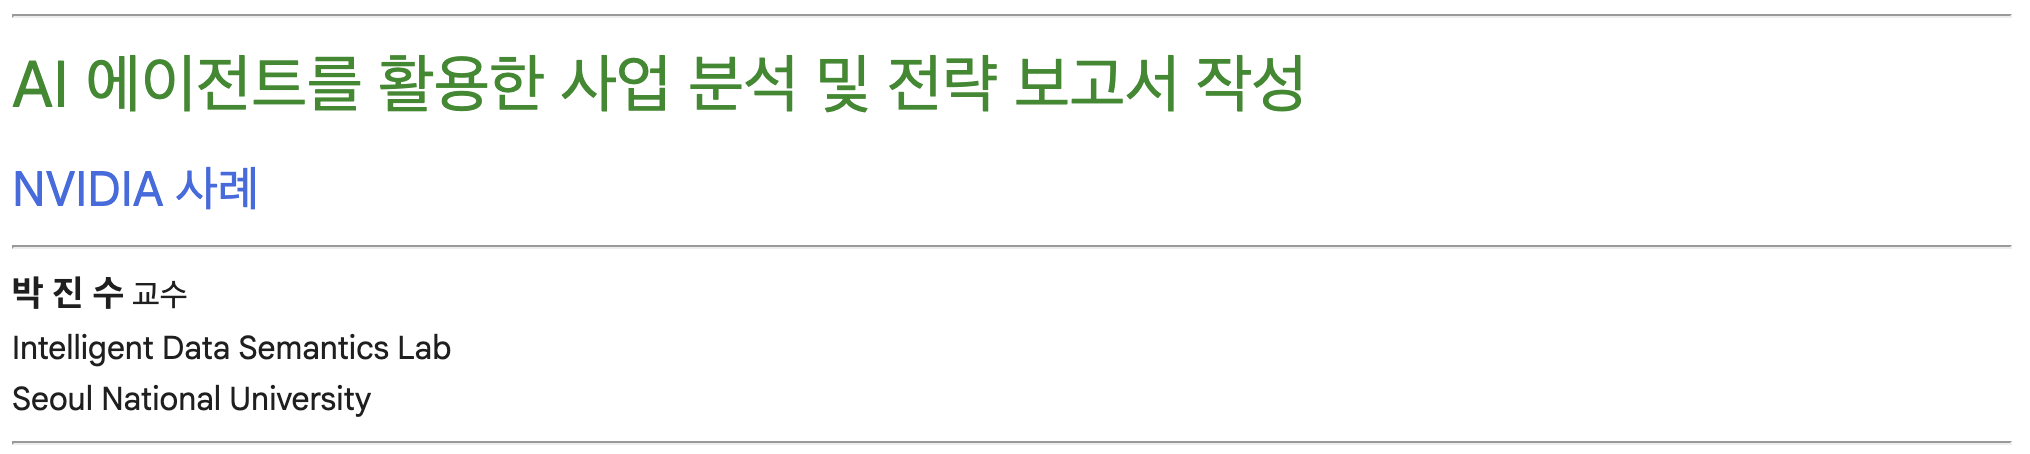

- - -

- 본 자료는 강의를 위한 목적으로 제작되었습니다.
- 본 자료에 대한 사전 허가를 받지 않는 배포를 금지합니다.
- 본 자료를 강의나 다른 목적으로 활용하고자 하시는 경우 꼭 아래 이메일 주소로 연락주세요.
- 연락처 : [jinsoo@snu.ac.kr](jinsoo@snu.ac.kr)

- - -

**<font size='+2'>목차**

>[Preparation](#scrollTo=D-ydfxr_SmNu)

>>[필요한 패키지 설치](#scrollTo=NWMOAzelS-Z4)

>>[Google Gemini API 설정](#scrollTo=QbstMfu0SvLH)

>>[[필요시] Google Gemini를 제외한 기타 API 설정](#scrollTo=iNohJk6gS_WV)

>>[툴 및 도우미 함수](#scrollTo=jln_UbuFTDXt)

>[과제 예시](#scrollTo=hzBEca8LSclp)

>>[1. 과제 주제](#scrollTo=NHaXzT1bUEKK)

>>[2. 업무 적용 시나리오](#scrollTo=74KR2F3tUbSG)

>>[3. 에이전트 워크플로우 도식](#scrollTo=fQ7tL8TEUfAh)

>>[4. 에이전트 활용](#scrollTo=wQDixgMIUk6R)

>>>[4-1. 10-K 문서 분석](#scrollTo=JW07Ug5ICBAX)

>>>[4-2. 연례 보고서 분석](#scrollTo=-52iol3qECXl)

>>>[4-3. 관련 뉴스 분석](#scrollTo=TTPYl5pCXP3q)

>>>[4-4. 경쟁사 정보 수집](#scrollTo=gDbn2AiRZwE0)

>>>[4-5. 종합 보고서 작성](#scrollTo=GzXZkUoubMb0)

>>>[4-6. 관련 이미지 생성](#scrollTo=OduvOYj7bTz6)

>>>[[참고] Whisk를 활용한 이미지 생성](#scrollTo=OOLFyCBbyQz3)



# **Preparation**

## 필요한 패키지 설치

In [ ]:
!pip install -qU pypdf markdownify litellm

## Google Gemini API 설정

**<font color='red' size='+1'>[주의] 아래 방법 중 <u>하나만 선택하</u>여 실행해야 합니다.</font>**

In [ ]:
# --- 방법 1
import os
from google.colab import userdata

os.environ['GEMINI_API_KEY'] = userdata.get('GOOGLE_API_KEY')  # (note) GEMINI_API_KEY, not GOOGLE_API_KEY for litellm

In [ ]:
# --- 방법 2 - API Key를 입력한다.
import os, getpass

os.environ['GEMINI_API_KEY'] = getpass.getpass('Enter Your Google API Key: ') # (note) GEMINI_API_KEY, not GOOGLE_API_KEY for litellm

## [필요시] Google Gemini를 제외한 기타 API 설정

**<font color='red' size='+1'>[주의] 아래 방법 중 <u>하나만 선택하</u>여 실행해야 합니다.</font>**

In [ ]:
# --- 방법 1 (API Key 명칭 수정 후 사용)
import os
from google.colab import userdata
os.environ['?????_API_KEY'] = userdata.get('?????_API_KEY')

In [ ]:
# --- 방법 2 (API Key 명칭 수정 후 사용) - API Key를 입력한다.
import os, getpass
os.environ['?????_API_KEY'] = getpass.getpass('Enter Your LLM API Key: ')

## 툴 및 도우미 함수

**❏ 툴 사용법**

**1. PDF 파서: pdf_parser**(path)
- path에 PDF 파일의 경로나 URL을 전달하면 PDF 파일을 언어 모델이 읽을 수 있는 텍스트 형태로 반환한다.

**2. 웹 파서: web_parser**(url)
- url에 파싱할 페이지의 url을 전달하면 웹 페이지 내용을 언어 모델이 읽을 수 있는 텍스트 형태로 반환한다.



In [ ]:
# --- PDF 파서: PDF 링크나 파일 경로를 입력 받아 PDF 파일의 텍스트 전체를 하나의 문자열로 반환
import requests, functools
from io import BytesIO
from pypdf import PdfReader


@functools.cache
def pdf_parser(path):
    pdf_file = None
    try:
        if path.startswith('http'):  # 입력 받은 경로가 URL인 경우 URL의 pdf 파일을 pdf_file에 저장
            response = requests.get(path, timeout=30)
            pdf_file = BytesIO(response.content)
        else:  # 입력 받은 path가 'http'로 시작하지 않으면 path를 로컬 파일로 가정하고 로컬 경로의 pdf 파일을 pdf_file에 저장
            with open(path, 'rb') as f:
                pdf_file = BytesIO(f.read())

        if not pdf_file:  # 잘못된 경로가 입력되어 pdf_file에 아무것도 없는 경우 오류 메시지 반환
            return 'PDF를 가져올 수 없습니다. 다시 시도해주세요'

        reader = PdfReader(pdf_file)
        all_text_content = []

        # 각 페이지의 텍스트를 all_text_content 리스트에 저장
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                all_text_content.append(page_text)

        # LLM에 전달할 수 있도록 하나의 문자열로 병합
        return '\n'.join(all_text_content).strip()
    except:
        return 'PDF 파일을 가져올 수 없습니다. 다시 시도해주세요'


In [ ]:
# --- 웹 파서: 웹 링크를 받아 파싱하여 마크다운으로 변환
import requests, functools
from bs4 import BeautifulSoup
from markdownify import markdownify


@functools.cache
def web_parser(url):
    """
    주어진 URL로부터 웹 페이지(url)를 요청하고, HTML에서 스크립트(script), 스타일(style),
    헤더(header), 푸터(footer), 내비게이션(nav) 등을 제거하고, 유효한 HTML 태그의 속성만
    남긴 뒤, 전체 HTML을 Markdown 형식으로 변환하여 반환하는 함수
    """
    try:
        response = requests.get(url, timeout=30)
        soup = BeautifulSoup(response.text, 'html.parser')

        # script, style, header, footer, nav 등 태그는 파싱하지 않도록 제거
        for script_or_style in soup(['script', 'style', 'header', 'footer', 'nav']):
            script_or_style.decompose()  # HTML 본문 내용과 관계 없는 태그를 제거(decompose)한다.

        # 파싱 및 마크다운화 하기 용이하도록 href, src, alt, title 외 속성은 모두 제거
        for tag in soup():  # HTML 태그들의 속성 중 유의미한 속성(href, src, alt, title)만 남긴다.
            if tag.attrs:   # 보안이나 깔끔한 결과를 위해 불필요한 속성 제거한다. 남기는 속성은 링크, 이미지 등 관련 정보다.
                tag.attrs = {key: value for key, value in tag.attrs.items() if key in ['href', 'src', 'alt', 'title']}

        # BeautifulSoup 객체를 문자열로 변환한 후, markdownify로 Markdown으로 변환한다.
        # heading_style='ATX' <- `# 제목` 스타일로 변환
        # default_title=True  <- 제목이 없으면 기본 제목을 삽입
        markdown_text = markdownify(str(soup), heading_style='ATX', default_title=True)
        return markdown_text
    except:
        return '오류가 발생했습니다. 다시 시도해주세요.'

**❏ 도우미 함수 사용법**

**1. get_response**(instruction, user_message, model='gemini/gemini-2.0-flash', tools=None, **kwargs)
- instruction에 시스템 프롬프트, user_message에 사용자 프롬프트를 전달하면 언어모델의 답변을 반환한다.
- model 기본값은 'gemini/gemini-2.0-flash'로 사고(reasoning) 모델인 Gemini 2.5 Flash를 활용하려면 'gemini/gemini-2.5-flash'을 전달한다.
    + 'openai/gpt-5', 'openai/gpt-5-mini' 등 다양한 모델 입력도 가능하다.
- tools의 기본값은 None으로, 모델이 **검색**을 활용해 답변해야 하는 경우 검색 도구를 전달한다.
-  **kwargs는 도우미 함수로 전달할 추가 파라미터로 `temperature`, `max_tokens`, `stop`, `top_p` 등이 있다.

**[참고]** Gemini 모델별 무료 사용자의 사용 제한은 아래와 같다.

| Model                                 | 분당 호출 수 | 분당 토큰 수 | 일당 호출 수 |
|---------------------------------------|-------------:|-------------:|-------------:|
| Gemini 2.5 Pro                        |            5 |     250,000 |           100 |
| Gemini 2.5 Flash                      |           10 |     250,000 |          250 |
| Gemini 2.0 Flash                      |           15 |   1,000,000 |        200 |
| Gemini 2.0 Flash Image Generation     |           10 |     200,000 |          100 |

</div>
<br/><br/>

**2. generate_image**(prompt)
- prompt에 생성할 이미지에 대한 프롬프트를 전달하면 Gemini 2.0 Flash Image Generation 모델 또는 GPT-IMAGE-1 모델을을 호출해 이미지를 생성해 출력한다.
- **'gemini-2.5-flash-image-preview'** 모델과 **'gpt-image-1'** 은 **무료 API Key 사용자가 사용할 수 없는 모델**이다.


**[참고]** gemini-2.5-flash-image-preview 모델의 Tier 1 이상 유료 사용자 기준 사용 한도는 아래와 같다.
- https://ai.google.dev/gemini-api/docs/rate-limits#tier-1


<table>
<tr><td>RPM(Request per Minute)</td><td>500 (분당 500회의 요청을 보낼 수 있다)</td></tr>
<tr><td>TPM(Tokens per Minute)</td><td>500,000 (분당 500,000토큰을 처리할 수 있다)</td></tr>
<tr><td>RPD(Request per Day)</td><td>2,000 (하루에 2,000회의 요청을 보낼 수 있다 / 한국 시간 기준 매일 오후 5시에 초기화)
</td></tr>
</table>
</div>




In [ ]:
# --- 도우미 함수
from litellm import completion, responses


execution_log = []  # 모델 출력값을 누적 저장하는 리스트 (자동으로 기록됨)
                    # 이전에 실행한 출력값을 확인하고 싶을 때 사용하면 된다.

# (note) 'gemini/gemini-2.5-flash' 모델은 'gemini/gemini-2.0-flash' 모델보다
#         처리 속도가 느리고, 분당 처리 가능한 토큰 수가 1/4이다.
def get_response(instruction, user_message, model='gemini/gemini-2.0-flash', tools=None, **kwargs):
    """
    대화형 AI 모델로부터 단일 응답만 받아오는 함수다. 도구(tools)가 필요하면 그 정보도 같이 전달한다.

    Args:
        instruction (str): 대화의 시스템 또는 개발자 지침 역할을 하는 문자열
            LLM에게 특정 행동 양식을 알려줄 때 사용한다. None이면 아무런 시스템 메시지도 전달하지 않는다.
        user_message (str): 사용자가 보내는 메시지로 LLM이 답변을 생성하는 데 사용한다.
        model (str): 호출할 LLM 모델의 이름
        tools (List[Any]): LLM 호출 시 사용할 도구들(tools) 리스트
            필요한 외부 기능을 연결할 때 사용한다. None이면 도구를 사용하지 않는다.
        **kwargs: litellm.completion()에 전달할 추가 파라미터
            (예: temperature, max_tokens, stop, top_p 등)

    Returns:
       str: 모델이 생성한 응답 문자열.
    """
    # 모델에 전달할 메시지 리스트 구성
    messages = []

    if instruction:
        messages.append({'role': 'developer', 'content': instruction})

    # OpenAI Models
    openai_models = (
        'openai/gpt-3.5-turbo', 'openai/gpt-3.5-turbo-instruct', 'openai/gpt-4',
        'openai/gpt-4o', 'openai/gpt-4o-mini', 'openai/gpt-4.1', 'openai/gpt-4.1-mini',
        'openai/gpt-4.1-nano', 'openai/gpt-5', 'openai/gpt-5-mini', 'openai/gpt-5-nano',
        'openai/gpt-5-codex', 'openai/gpt-5-chat-latest', 'openai/o1', 'openai/o1-mini',
        'openai/o1-pro', 'openai/o3', 'openai/o3-mini', 'openai/o4-mini',
        'openai/o4-mini-deep-research'
    )
    if model in openai_models: # OpenAI 모델이면 litellm의 responses 함수를 호출해서 응답을 생성한다.
        # responses 함수에 맞는 매핑값으로 수정하여 메세지를 추가한다.
        messages.append({'role': 'user','content': [{'type': 'input_text', 'text': user_message}]})
        # litellm의 responses 함수를 호출해서 응답 생성
        response = responses(model=model, input=messages, tools=tools)
        # 생성한 AI 응답을 가져온다.
        ai_message = response['output'][-1].content[-1].text
    else: # 그 외의 모델은 litellm의 completion 함수를 호출해서 응답을 생성한다.
        # 일부 모델(e.g., Anthropic)은 사용자 메시지가 반드시 필요하므로 빈 문자열이라도 추가한다.
        messages.append({'role': 'user','content': [{'type': 'text', 'text': user_message or ''}]})
        # litellm의 completion 함수를 호출해서 응답 생성
        response = completion(model=model, messages=messages, tools=tools)
        # 생성한 AI 응답을 가져온다.
        ai_message = response.choices[0].message.content

    # 모델 출력값을 누적으로 저장 (필요시 사용)
    execution_log.append(ai_message)

    # 모델 응답을 반환한다.
    return ai_message

- - -
**<font size='+1'>💡 참고:</font>** Anthropic은 아직 이미지 생성 모델을 출시하지 않았다.
- - -

In [ ]:
# --- 이미지 생성 도우미 함수
import base64
from google import genai
from google.genai import types
from openai import OpenAI
from typing import Literal
from IPython.display import Image, display
from google.colab import userdata

# Gemini 2.0 Flash Image Generation 모델 또는 GPT-IMAGE-1 모델을 활용해 이미지 생성 후 이미지 URL을 반환
def generate_image(prompt: str, model: Literal['gemini', 'gpt'] = 'gemini') -> str:
    """
    선택한 모델(Gemini 또는 GPT)을 사용하여 이미지를 생성하고 URL을 반환한다.

    Args:
        prompt (str): 이미지 생성을 위한 텍스트 프롬프트
        model (Literal['gemini', 'gpt']): 사용할 이미지 생성 모델 선택
            - 'gemini': Google Gemini 2.0 Flash Image 모델
            - 'gpt': OpenAI GPT 이미지 모델 (gpt-image-1)

    Returns:
        str: 생성한 이미지의 Base64 인코딩 데이터 URL (data:image/png;base64, ...)
    """

    if not prompt:
        raise ValueError('ERROR: prompt가 필요합니다. 이미지 생성을 위한 설명을 입력하세요.')

    user_choice = model.lower().strip()

    # --- Google Gemini --------------------------------------------------------
    if user_choice == 'gemini':
        client = genai.Client(api_key=userdata.get('GOOGLE_API_KEY'))
        model_name = 'gemini-2.0-flash-preview-image-generation'
        response = client.models.generate_content(
            model=model_name,
            contents=prompt,
            config=types.GenerateContentConfig(
                response_modalities=['TEXT', 'IMAGE']
            )
        )
        # 이미지 데이터 추출
        image_data = None
        for part in response.candidates[0].content.parts:
            if getattr(part, 'inline_data', None):
                image_data = part.inline_data.data
                break
        if image_data is None:
            raise ValueError('ERROR: Gemini 모델에서 이미지 데이터를 찾을 수 없습니다.')

        # base64 → data URL 변환
        img_b64 = base64.b64encode(image_data).decode('utf-8')
        image_url = f'data:image/png;base64,{img_b64}'
    # --- OpenAI GPT -----------------------------------------------------------
    elif user_choice == 'gpt':
        client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
        model_name = 'gpt-image-1'
        response = client.images.generate(model=model_name, prompt=prompt)
        b64_image = response.data[0].b64_json
        image_url = f'data:image/png;base64,{b64_image}'
    # --- 예외 처리 --------------------------------------------------------------
    else:
        raise ValueError(f'지원되지 않는 이미지 생성 모델 선택: {user_choice!r}')

    display(Image(url=image_url))

# **과제 예시**

## **1. 과제 주제**

**과제 주제**:
- NVIDIA의 2025 회계연도(Fiscal Year 2025) 수익 견인 요인과 향후 전략 분석에 관한 보고서 작성
- **참고**: NVIDIA의 2025 회계연도는 2024년 1월 29일부터 2025년 1월 26일이다.

**과제 주제 선정 사유**:
- 에이전트와 툴을 활용하여 복잡한 분석 작업을 자동화함으로써 분석 속도와 정확도를 높인다.

- 생성형 AI를 통해 기업의 공식 보고서와 외부 데이터를 종합적으로 분석하고, 인사이트 중심의 보고서를 작성한다.

- 방대한 정보를 선별하고 요약하는 과정을 통해 핵심 수익 요인을 파악한다.

- 분석 결과를 실제 업무에 활용 가능한 형태로 재구성함으로써 보고서 작성 역량을 강화한다.

- 데이터 기반 경영 분석 업무에 생성형 AI를 실질적으로 적용하는 방법을 탐색한다.

## **2. 업무 적용 시나리오** ##

- 기획전략실에서 연간 사업계획 수립, 투자자 대상 발표 자료 작성, 경쟁사 벤치마킹 리포트 작성 등의 업무를 수행할 때, 기업의 재무보고서와 시장 뉴스를 빠르게 분석해 수익 구조와 성장 요인을 정리해야 하는 상황이 발생한다.

- 이러한 상황에서 생성형 AI 기반 에이전트를 활용하면, 10-K 보고서, 연례 보고서, 관련 뉴스 기사 등 방대한 자료를 자동으로 파싱하고 요약할 수 있으며, 이를 기반으로 핵심 매출 견인 요인을 도출하고 보고서 형식으로 정리할 수 있다.

- 사업 부문별 매출 흐름과 외부 환경 요인을 연결하여 설명하는 방식은 실제 전략 보고서 작성이나 IR 자료 구성 시 바로 적용 가능하다.

- 반복적인 분석과 요약 작업을 자동화함으로써 실무자의 분석 시간을 단축시키고, 보다 전략적인 해석과 의사결정에 집중할 수 있도록 지원하는 실질적 도구로 활용될 수 있다.

## **3. 에이전트 워크플로우 도식** ##

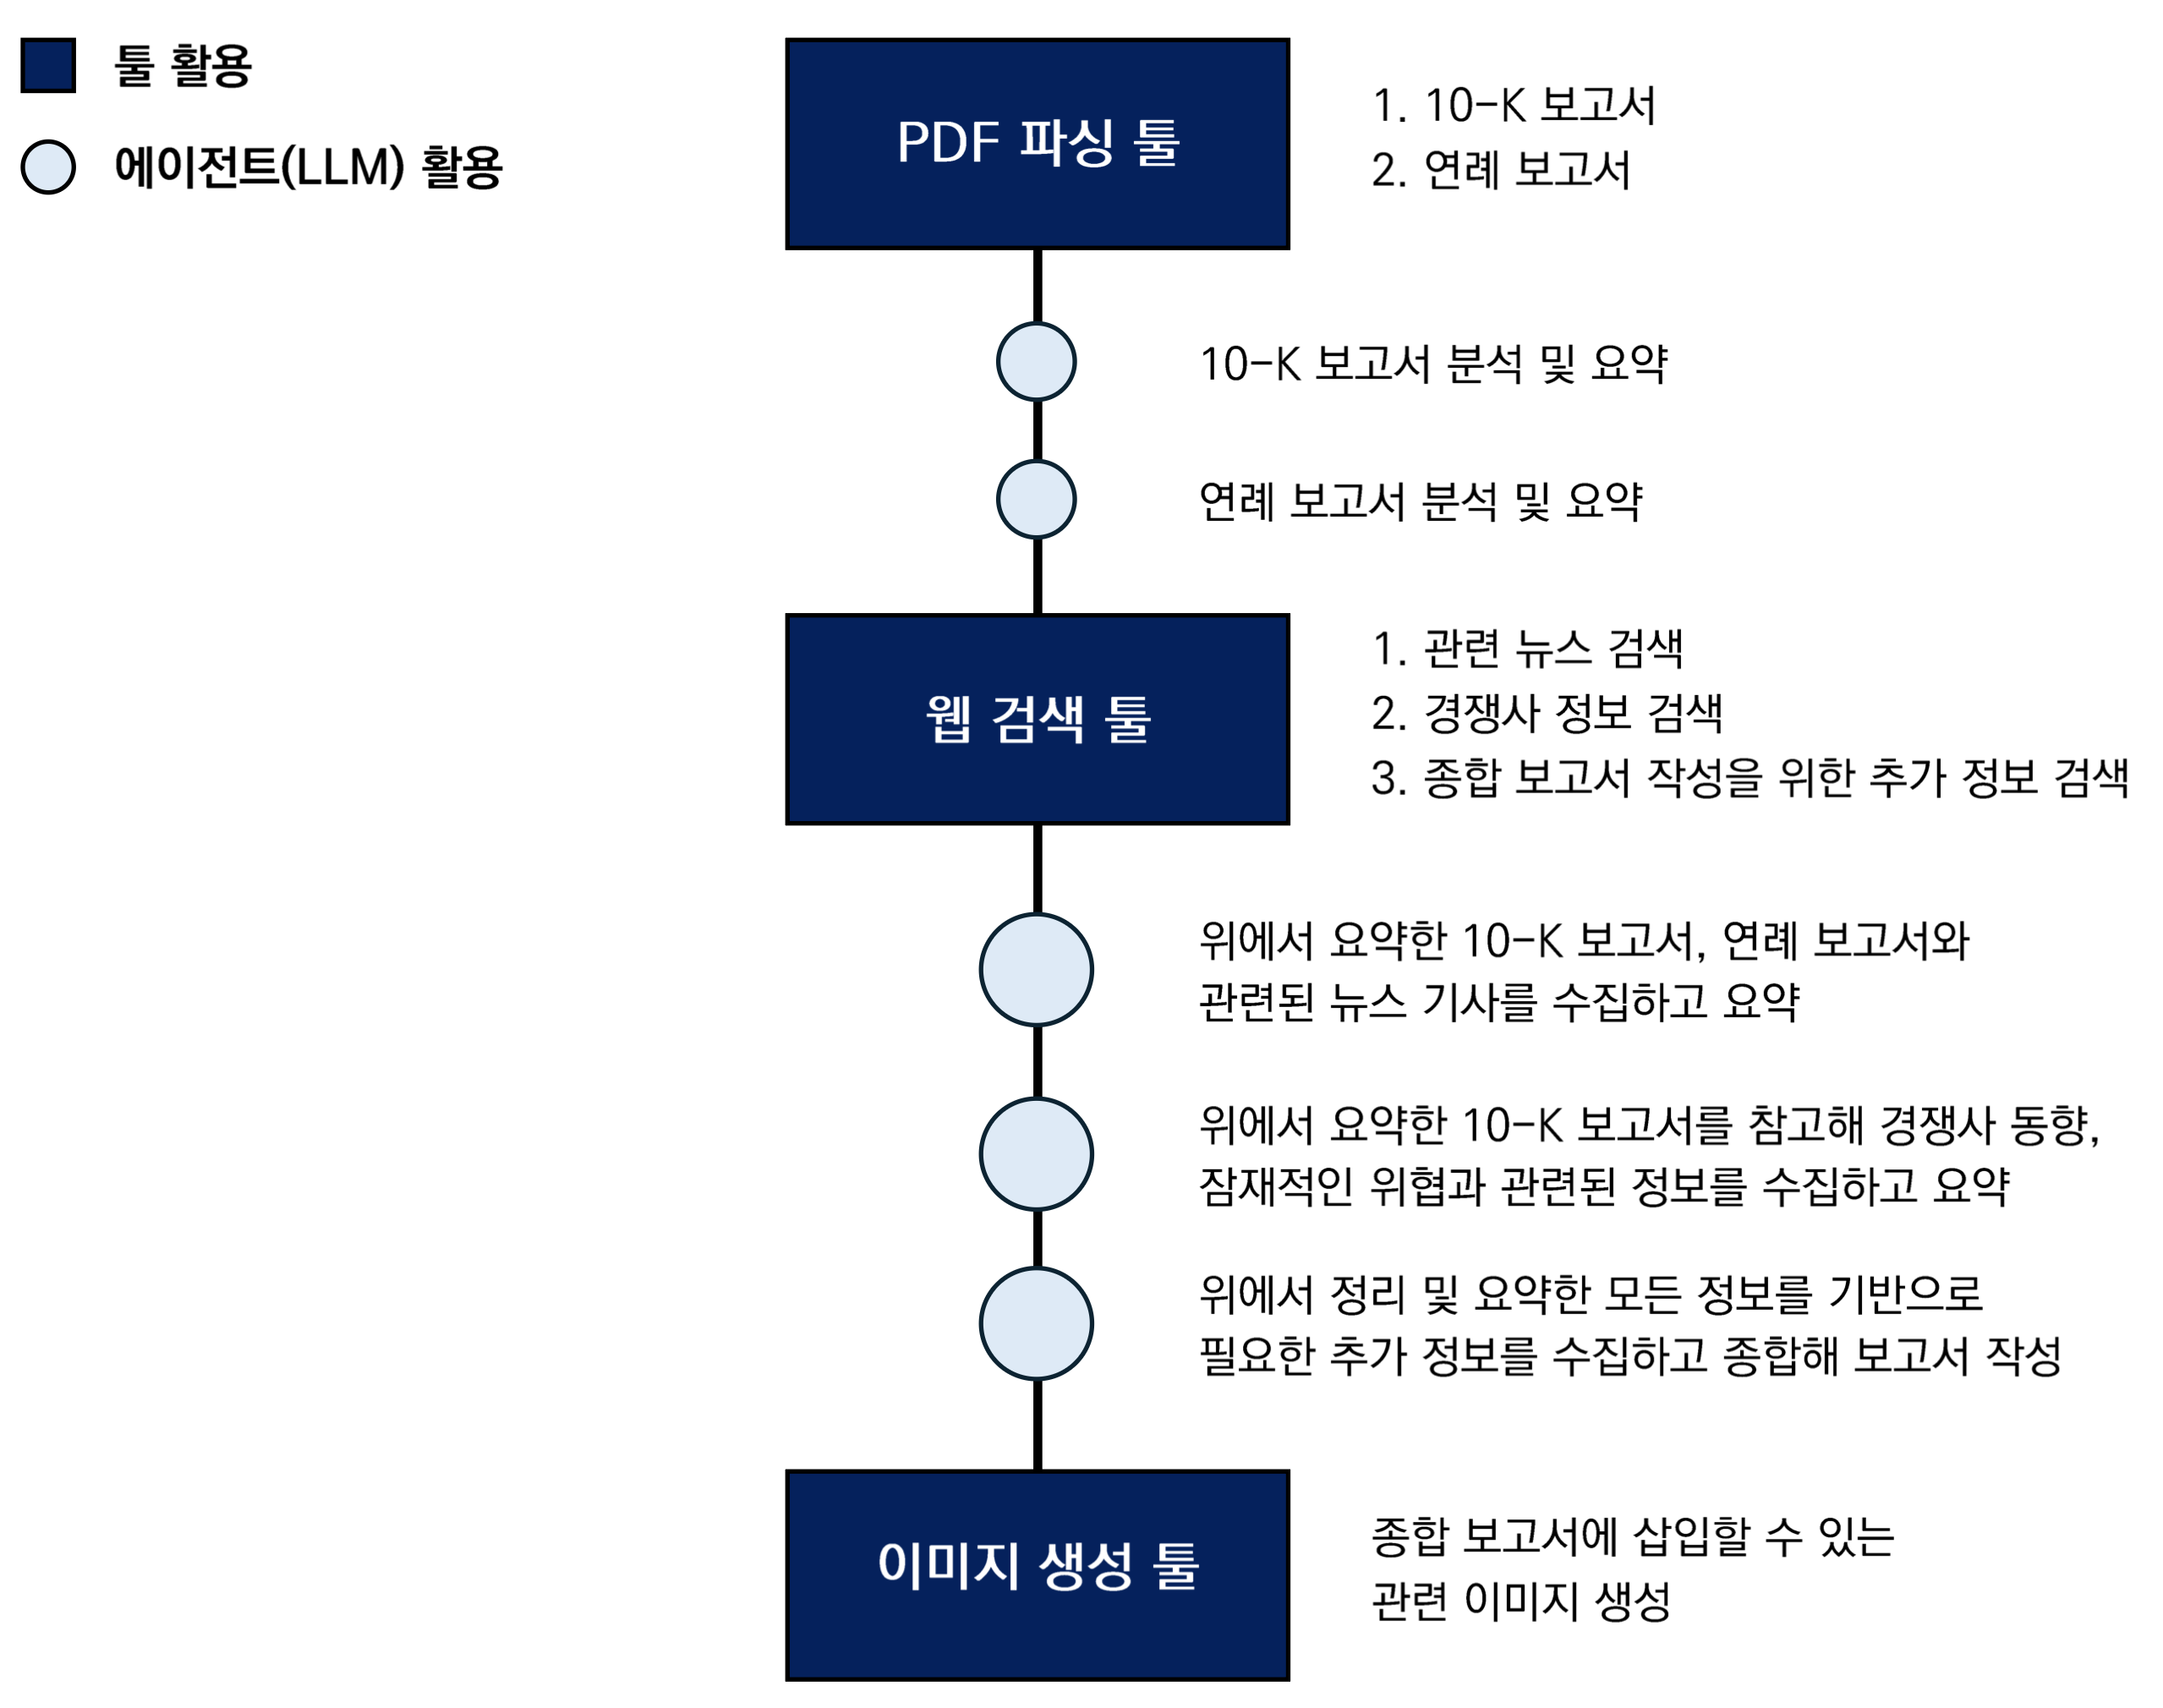

## **4. 에이전트 활용**

### **4-1. 10-K 문서 분석**

NVIDIA 2025 회계연도 10-K 보고서
- https://s201.q4cdn.com/141608511/files/doc_financials/2025/q4/177440d5-3b32-4185-8cc8-95500a9dc783.pdf

- **참고**: NVIDIA의 2025 회계연도는 2024년 1월 29일부터 2025년 1월 26일이다.

In [ ]:
# --- PDF 파일을 가져와 일반 텍스트 파일로 바꾼다.
# (caution) 문서가 매우 크면 인덱싱을 해야 한다.
# 이 실습은 개념 전달이 목적이기 때문에 문서분할-임베딩-벡터스토어 인덱싱 과정을 생략한다.
# 참고: RAG(Retrieval Augmented Generation)
report_10k = pdf_parser('https://s201.q4cdn.com/141608511/files/doc_financials/2025/q4/177440d5-3b32-4185-8cc8-95500a9dc783.pdf')
# print(report_10k)

In [ ]:
system_instruction = '''당신은 10-K 리포트를 읽고 분석하여 \
상세한 결과물을 제공하는 뛰어난 분석가입니다. 분석 결과 보고서는 \
한국어로 작성합니다. 출력은 항상 마크다운 형식으로 해주세요. \
제목, 목록, 표, 코드 블록 등 구조를 명확히 표현하고, \
단순 텍스트라도 항상 마크다운 규칙을 적용해 주세요.
'''
user_prompt = f'''아래 주어지는 NVIDIA의 10-K 리포트를 읽고 \
2024 회계연도에서 2025 회계연도의 매출 추이와 매출 견인 요인들을 \
최대한 상세히 분석해주세요.
10-K REPORT: {report_10k}
'''

summary_10k = get_response(system_instruction, user_prompt)

In [ ]:
from IPython.display import Markdown
Markdown(summary_10k)

### **4-2. 연례 보고서 분석**

NVIDIA 2025 회계연도 연례 보고서 분석
- https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/80be65cd-c965-4af3-b42f-ec3c0d75f16f.pdf
- **참고**: NVIDIA의 2025 회계연도는 2024년 1월 29일부터 2025년 1월 26일이다.

In [ ]:
# --- NVIDIA의 2025년도 회계연도 연례 보고서 PDF 파일을 가져와 일반 텍스트 파일로 바꾼다.
# (caution) 문서가 매우 크면 인덱싱을 해야 한다.
# 이 실습은 개념 전달이 목적이기 때문에 문서분할-임베딩-벡터스토어 인덱싱 과정을 생략한다.
# 참고: RAG(Retrieval Augmented Generation)

annual_report = pdf_parser('https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/80be65cd-c965-4af3-b42f-ec3c0d75f16f.pdf')
print(annual_report)

In [ ]:
system_instruction = '''당신은 연례 보고서를 읽고 분석하는 \
경험이 풍부한 전문가입니다. 분석 결과 보고서는 한국어로 작성합니다. \
출력은 항상 마크다운 형식으로 해주세요. 제목, 목록, 표, 코드 블록 등 \
구조를 명확히 표현하고, 단순 텍스트라도 항상 마크다운 규칙을 적용해 주세요.
'''
user_prompt = f'''아래 주어지는 NVIDIA의 연례 보고서를 읽고 \
2024 회계연도에서 2025 회계연도의 매출 추이와 매출 견인 요인들을 \
최대한 상세히 분석해주세요.

ANUUAL REPORT FOR SECURITIES HOLDERS: {annual_report}
'''

summary_annual = get_response(system_instruction, user_prompt)

In [ ]:
Markdown(summary_annual)

### **4-3. 관련 뉴스 분석**

In [ ]:
system_instruction = '''당신은 분석 자료를 토대로 관련 뉴스 기사를 \
수집하는 경험이 풍부한 시니어 조사 연구원입니다. 주어진 분석 자료에서 \
주요 주제들을 찾아, 각 주제별로 뉴스 기사를 최소 3개 이상을 웹 검색으로 \
수집해야 합니다. 또한, 당신은 각 뉴스들을 보고서에 삽입할 수 있도록 \
뉴스별로 최소 1문단(6문장 이상) 이상으로 자세하고 사업적인 관점에서 \
요약합니다. 또한, 웹에서 참고한 각 기사마다 **반드시** URL을 명확히 \
남겨야 합니다. 당신의 답변은 주어진 보고서나 웹 검색 결과만을 기반으로 \
작성하세요. 당신이 알고 있는 지식이나 가정에 의존하여 답해서는 안 됩니다. \
절대로 답을 지어내려고 하지 마세요. 출력은 항상 마크다운 형식으로 해주세요.
제목, 목록, 표, 코드 블록 등 구조를 명확히 표현하고, 단순 텍스트라도 \
항상 마크다운 규칙을 적용해 주세요.
'''
user_prompt = f'''아래 두 개의 보고서를 읽고 관련 뉴스 기사를 \
수집한 후, 각 뉴스별로 요약해주세요.

<10-K 분석 요약 보고서>
{summary_10k}
</10-K 분석 요약 보고서>

<연례 보고서 분석 요약 보고서>
{summary_annual}
</연례 보고서 분석 요약 보고서>
'''
# litellm은 tools를 google.genai.types.Tool 객체가 아닌 딕셔너리 리스트로 예상한다.
# 따라서 딕셔너리 형식을 사용하여 Google Search 도구를 정의한다.
# (note) 이 예시에서는 구글 검색 도구를 사용하는 것을 가정한다.
tools = [{'googleSearch': {}}]  # for Google Gemini
# tools = [{'type': 'web_search'}]  # for OpenAI
# tools = [{'type': 'web_search_20250305', 'name': 'web_search', 'max_uses': 5}] # for Anthropic (default 'max_uses'=10)

news = get_response(system_instruction, user_prompt, tools=tools)

In [ ]:
Markdown(news)

### **4-4. 경쟁사 정보 수집**

In [ ]:
system_instruction = '''당신은 NVIDIA 전략기획부서의 \
전략기획 지원 담당자입니다. 당신의 주요 업무는 경쟁사의 **현황**과 \
이와 관련된 **잠재적인 위협**을 인터넷에서 조사해야 합니다.\
당신의 답변은 주어진 보고서나 웹 검색 결과만을 기반으로 작성하세요. \
당신이 알고 있는 지식이나 가정에 의존하여 답해서는 안 됩니다. \
절대로 답을 지어내려고 하지 마세요. 출력은 항상 마크다운 형식으로 \
해주세요. 제목, 목록, 표, 코드 블록 등 구조를 명확히 표현하고, \
단순 텍스트라도 항상 마크다운 규칙을 적용해 주세요.
'''
user_prompt = f'''NVIDIA의 경쟁사의 2025년도 소식들을 \
알려주세요. 특히 NVIDIA의 2025 회계연도 10-K report를 읽고 \
NVIDIA에 위협이 될만한 것들을 위주로 조사해서 보고서를 자세히 \
작성해주세요. 조사한 자료들의 URL도 함께 남겨주세요.

<10-K 보고서>
{report_10k}
</10-K 보고서>
'''

competitors = get_response(system_instruction, user_prompt, tools=tools)

In [ ]:
Markdown(competitors)

### **4-5. 종합 보고서 작성**

In [ ]:
system_instruction = '''당신은 NVIDIA 전략기획부서의 \
시니어 매니저입니다. 당신의 주 임무는 주어진 보고서와 요약문들을 \
토대로 새로운 사업 분석 및 전략 보고서를 만드는 것입니다. \
필요하다면 웹 검색을 통해 자료를 보강해주세요. 당신의 답변은 \
주어진 보고서나 웹 검색 결과만을 기반으로 작성하세요. \
당신이 알고 있는 지식이나 가정에 의존하여 답해서는 안 됩니다. \
절대로 답을 지어내려고 하지 마세요. 출력은 항상 마크다운 형식으로 \
해주세요. 제목, 목록, 표, 코드 블록 등 구조를 명확히 표현하고, \
단순 텍스트라도 항상 마크다운 규칙을 적용해 주세요.
'''
user_prompt = f'''아래 주어지는 보고서들과 뉴스들을 종합해서 \
최소 1500 단어 이상 분량의 보고서를 작성하세요.

<10-K 분석 요약 보고서>
{summary_10k}
</10-K 분석 요약 보고서>

<연례 보고서 분석 요약 보고서>
{summary_annual}
</연례 보고서 분석 요약 보고서>

<뉴스 기사 분석 요약 보고서>
{news}
</뉴스 기사 분석 요약 보고서>

<경쟁사 분석 요약 보고서>
{competitors}
</경쟁사 분석 요약 보고서>
'''

final_report = get_response(system_instruction, user_prompt, tools=tools)

In [ ]:
Markdown(final_report)

### **4-6. 관련 이미지 생성**


**[참고]** 이미지 생성이 정상적으로 되지 않는다면 런타임을 다시 시작한 후 [툴 및 도우미 함수] 섹션을 다시 실행한다.

In [ ]:
system_instruction = '''당신은 이미지 생성을 잘 할 수 있도록 \
도와주는 이미지 생성 프롬프트 작가입니다. 주어진 내용을 이미지로 \
가장 잘 표현할 수 있는 영어 프롬프트를 제안하세요.
'''
user_prompt = f'''주어진 보고서를 검토한 후 해당 보고서에 \
시각 자료를 추가할 수 있는 이미지를 생성하기 위한 프롬프트를 \
3개 이상 추천해주세요.

<보고서>
{final_report}
</보고서>
'''

image_prompts = get_response(system_instruction, user_prompt)

In [ ]:
Markdown(image_prompts)

In [ ]:
# 위에서 제안한 프롬프트 중 하나를 선택해서 prompt를 완성하세요.
prompt = '''

'''

# 이미지 생성 툴을 활용하면 이미지를 반환하지 않고 바로 출력하기 때문에 별도로 캡처하거나 저장해야 한다.
# 이미지 생성 툴을 활용할 때는 프롬프트를 영어로 전달하는 것이 좋다.
# model 파라미터의 선택지로는 'gemini'와 'gpt' 중에서 선택할 수 있다.
generate_image(prompt, model='gemini')
# generate_image(prompt, model='gpt')

### **[참고] Whisk를 활용한 이미지 생성**

**Whisk란?**
- Whisk는 Google의 실험적 AI 미디어 생성용 웹 서비스(https://labs.google/fx/tools/whisk)
- 구글의 이미지 생성 모델 Imagen4와 영상 생성 모델 Veo2를 사용해 이미지/영상을 **무료**로 생성할 수 있다.
    + 구글이 보유한 이미지 생성 모델 **Imagen**과 영상 생성 모델 **Veo**를 활용하는데 최적화되도록 설계했다.
- 단, 영상 생성의 경우 Whisk 내에서 생성한 이미지를 영상화하는 방법밖에 지원하지 않는다는 것은 단점이다.

**Whisk의 생성 한도**

- Whisk에서 이미지를 생성할 경우 Imagen4 모델을 이용하며, 한번에 최대 6개의 이미지를 무제한으로 생성할 수 있다.
- 또한, 영상 생성은 Whisk에서 제작한 이미지에 한정하여 생성할 수 있으며, 무료 계정은 한 달에 10개까지 무료로 생성할 수 있다. (Pro 계정은 한달에 100개까지 생성 가능)

| 계정 종류         | 이미지 생성 (Imagen4)   | 영상 생성 (Veo2)   |
|------------------|-------------------------|--------------------|
| 무료 계정        | 무제한 사용 가능        | 10회 / 월          |
| 유료 계정 (Pro)  | 무제한 사용 가능        | 100회 / 월         |

**1) NVIDIA의 폭발적인 성장과 AI 혁신을 시각적으로 표현:**

- **프롬프트**
```markdown
Futuristic cityscape dominated by towering data centers interconnected by
glowing fiber optic cables. In the foreground, a stylized NVIDIA chip with
intricate AI circuitry pulsates with energy. The sky above displays a
vibrant aurora borealis, symbolizing innovation and technological
advancement. The overall mood is optimistic and forward-looking.
```

- **이미지**
  <img width="80%" src="https://github.com/user-attachments/assets/e37b2091-25ec-4a1a-aa37-b3c2bbafaef0" />

- **영상**  
  <img width="80%" src="https://github.com/user-attachments/assets/9cc4bdb7-9a73-4407-94b1-9c0fdc1e9084" />

**2) NVIDIA의 사업 부문별 성장률 비교:**

- **프롬프트**
```markdown
A dynamic bar graph visualization showcasing the revenue growth of NVIDIA's
Compute & Networking and Graphics segments from 2023 to 2025. The Compute &
Networking bar dramatically increases, dwarfing the Graphics bar. Use a
color scheme of deep blues and greens, with subtle geometric patterns in the
background representing data flow and processing power. Add small icons
representing data centers and gaming consoles above each bar for context.
```

- **이미지**
  <img width="80%" src="https://github.com/user-attachments/assets/5e2df588-23e4-492e-ba02-2de6af7ae935" />

- **영상**  
  <img width="80%" src="https://github.com/user-attachments/assets/7c178637-296c-48e4-ac81-238723e458ca" />


**3) NVIDIA의 경쟁 환경과 위협 요소를 상징적으로 표현:**

- **프롬프트**
```markdown
A lone NVIDIA chip stands atop a rocky peak, surrounded by ominous storm
 clouds representing competition and potential threats. Lightning strikes
 illuminate the silhouettes of rival companies like AMD and Intel in the
 distance. The overall color palette is dark and dramatic, with flashes of
 vibrant color highlighting NVIDIA's resilience and innovation. Include
 subtle details like tangled cables and broken circuits to symbolize supply
 chain challenges and product defects.
```

- **이미지**  
<img width="80%" src="https://github.com/user-attachments/assets/d1123850-3c34-4c3d-8da1-24e96f8337ab" />

- **영상**  
<img width="80%" src="https://github.com/user-attachments/assets/764fbcb7-8b13-406c-a9ab-9d3699ad54b4" />

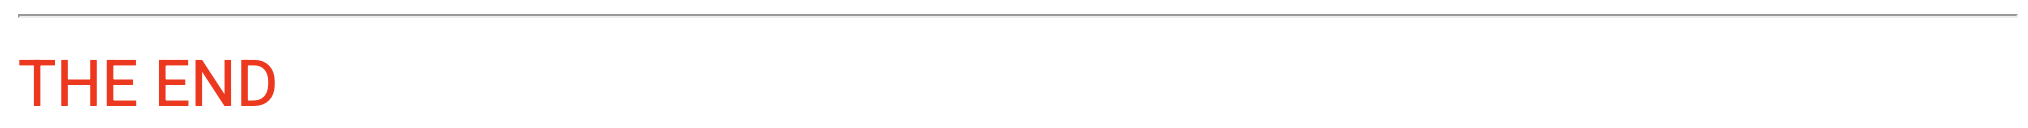